# Distance->Connection probability of Inhibitory cells underlying surround suppression

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
This is premised on exercise 3 of Workshop 2 where we analyzed the relationship between distance between L3-IT neurons and their connectedness. Here, we will extend this analysis to other cell types, in particular inhibitory cells.

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F3D8F5;">

# What is the inhibitory connectivity underlying surround suppression in the mouse primary visual cortex?

## Background
Surround suppression is a feature of sensory processing which, in visual systems, facilitates the definition of objects against their backgrounds (Kiniklioglu & Kaiser, 2025) by sharpening receptive fields as suppression strength increases (Plomp et al., 2019). While much work has been directed to describing the functional aspect of surround suppression, the underlying inhibitory structural connectivity has received less attention. We propose the use of the V1DD dataset, which comprises both structural and functional data, to address several questions about the inhibitory connectivity subserving surround suppression across the layers of the mouse primary visual cortex. 
    
## Methods
### Feature extraction:
Morphological metrics: total axonal length/radius, branch counts, maximum branch order, output synapse counts, synaptic density per unit length, number of distinct target types, layer/radial distributions, soma depth
Activity metrics: Differences in ΔF/F for windowed gabor - full-field gabor, suppression index
Synapse spatial targeting: Comparison of SOM+ vs other inhibitory interneurons for probability of synapsing
    
## Statistics:
Make a null connectivity model (by shuffling connections between cells): If the cell is connected to the inhibitory cells, then this cell may be more functionally capable of doing surround suppression, and the cells that could have been connected to inhibitory cells, will be less capable. Whether this is actually the case is unclear, and making a null connectivity model will help with this question.
Spearman correlation for cell connectivity probabilities? Maybe could do paired tests, depends on the final form of data.

In [1]:
# Import packages
import sys
from os.path import join as pjoin
import platform

import itertools
import pandas as pd
import numpy as np
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
#sys.path.append(utils_dir)
#from utils import filter_synapse_table, calculate_lateral_distances

# and utility code
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)
from data_io import *
from utils import filter_synapse_table, check_index, adjacencyplot#, calculate_lateral_distances
from data_io import _get_data_dir

In [2]:
from IPython.display import clear_output
clear_output(wait=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Utility function to calculate distances
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load synapse, proofreading and cell type information.
</div>

In [2]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(pjoin(data_dir, f'proofread_dendrite_list_{mat_version}.npy'))
axon_proof_root_ids = np.load(pjoin(data_dir, f'proofread_axon_list_{mat_version}.npy'))

print(f'There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading')
print(f'The number of cells with usable axons and dendrites is: {len(np.isin(axon_proof_root_ids, dendrite_proof_root_ids))}')

There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1210


In [3]:
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

In [4]:
cell_df["cell_type"].value_counts()

cell_type
L6-CT    11260
L4-IT     7955
L3-IT     6361
L6-IT     6044
L5-IT     5090
L2-IT     3073
PTC       2951
L5-ET     2013
DTC       1933
ITC       1090
STC        723
L5-NP      699
Name: count, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Select an inhibitory subtype from the list above (recommend start: PTC) and plot the cell locations in the plane parallel to the cortical layers (as in the Workshop). Highlight the cells with proofread axons.

The cell type abbreviations are 

<ul>
  <li>PTC: Perisomatic targeting cells (e.g., basket cells)</li>
  <li>DTC: Distal dendrite targeting cells (e.g., somatostatin cells)</li>
  <li>STC: Sparse targeting cells (e.g., neurogliaform cells)</li>
  <li>ITC: Inhibitory targeting cells (e.g., bipolar cells)</li>
</ul>

See [Schneider-Mizell, et al., 2025](https://www.nature.com/articles/s41586-024-07780-8) for more details on these types.

</div>

In [7]:
# YOUR CODE HERE
sub_cell_df_L4IT = cell_df[cell_df["cell_type"] == "L6-IT"]
sub_cell_df_L4IT.head(5)

sub_cell_df_L3IT = cell_df[cell_df["cell_type"] == "L3-IT"]
sub_cell_df_L3IT.head(5)

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type
2,203262,624.680,531.094,283.770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT
80,206060,638.648,534.819,413.820,-241.455293,242.581092,150.727000,864691132956447079,304.910673,E,L3-IT
100,427264,1162.836,530.629,283.095,286.300489,200.408581,20.827725,864691132726948075,337.056665,E,L3-IT
176,349313,900.160,569.118,73.305,24.765534,182.277697,-195.233083,864691132717799744,402.068640,E,L3-IT
190,351373,944.314,572.378,210.330,66.224682,222.567876,-57.252409,864691132656979312,277.321739,E,L3-IT


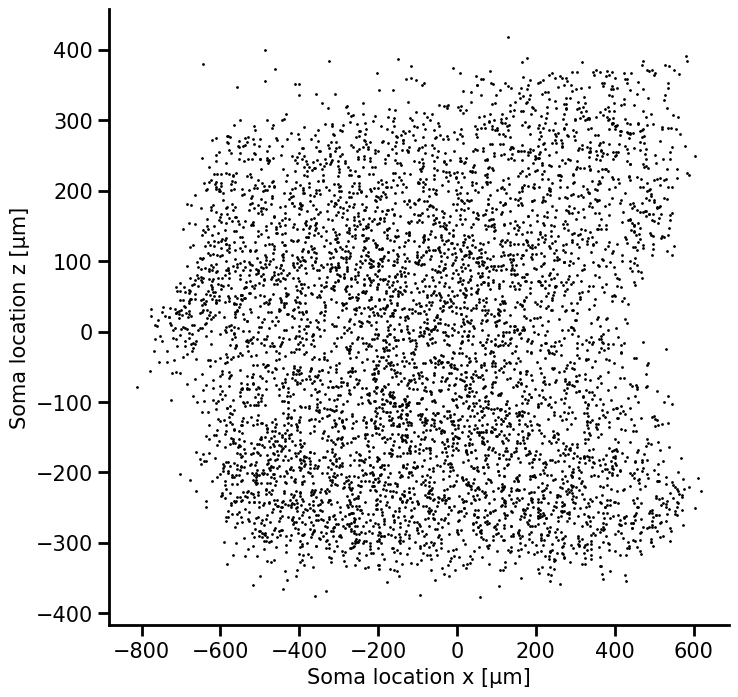

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(data=sub_cell_df_L4IT, x="pt_position_trform_x", y="pt_position_trform_z", c="k", s=1)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Soma location x [µm]", fontsize=15)
ax.set_ylabel("Soma location z [µm]", fontsize=15)

plt.show()

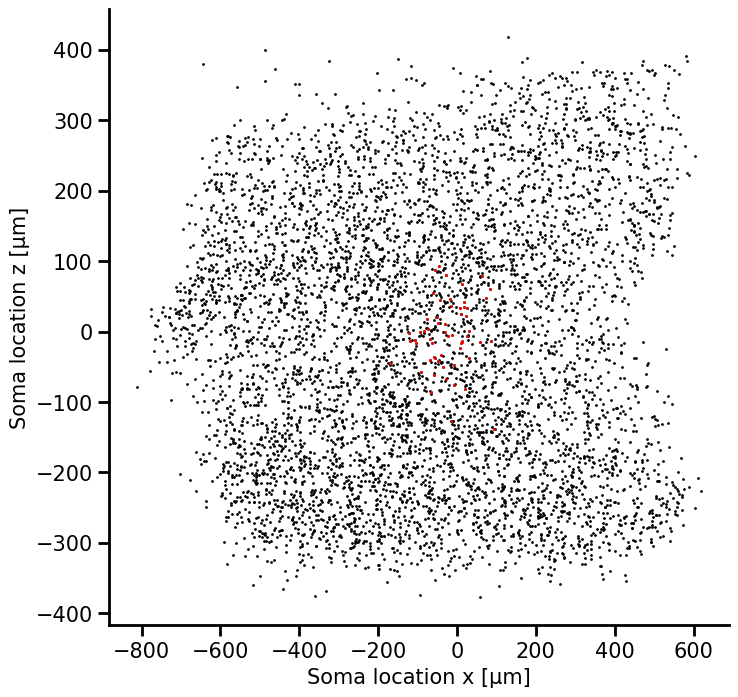

In [9]:
# Highlight the cells with proofread axons.
sub_cell_axon_proofread_df = sub_cell_df_L4IT[np.isin(sub_cell_df_L4IT["pt_root_id"], axon_proof_root_ids)]

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(data=sub_cell_df_L4IT, x="pt_position_trform_x", y="pt_position_trform_z", c="k", s=1)
ax.scatter(data=sub_cell_axon_proofread_df, x="pt_position_trform_x", y="pt_position_trform_z", c="r", s=1)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

ax.set_xlabel("Soma location x [µm]", fontsize=15)
ax.set_ylabel("Soma location z [µm]", fontsize=15)

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Recretate the neuron-neuron distance histogram from the workshop for a different pair of cell types. In the workshop, we evaluated the distance-connectivity relation for potential connections from L3-IT cells to L3-IT cells. Here, recreate this analysis for PTCs to L3-IT cells. Create two separate "sub_cell_df". "calculate_lateral_distances" takes two dataframes (pre and post) and returns the distances between all possible pairs of pre and post cells. 

</div>

In [10]:
# YOUR CODE HERE
# This will take a minute to complete
lateral_distance_df = calculate_lateral_distances(sub_cell_df_L4IT, sub_cell_df_L3IT)
lateral_distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
0,864691132596373823,864691132654552792,399.650263
1,864691132596373823,864691132956447079,356.686618
2,864691132596373823,864691132726948075,900.180007
3,864691132596373823,864691132717799744,750.574113
4,864691132596373823,864691132656979312,717.464930


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Convert the histograms into connection probabilities by dividing the counts (connected vs all) for each bin. Create a plot that shows Connection probability vs distance. 

</div>

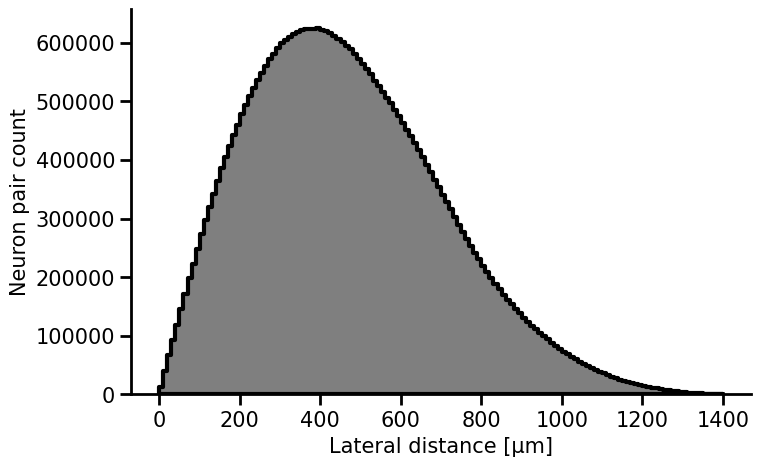

In [11]:
# Neuron pair count Vs distance
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Neuron pair count", fontsize=15)

plt.show()

In [12]:
# Gathering proofread L4-IT IDs and L3_IT IDS
pre_root_ids = sub_cell_df_L4IT["pt_root_id"][np.isin(sub_cell_df_L4IT["pt_root_id"], axon_proof_root_ids)]
post_root_ids = sub_cell_df_L3IT["pt_root_id"][np.isin(sub_cell_df_L3IT["pt_root_id"], dendrite_proof_root_ids)]

In [13]:
# filter the distance dataframe and comparing it to the unfiltered version
lateral_distance_proofread_df = lateral_distance_df.copy()
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["pre_pt_root_id"], pre_root_ids)]
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["post_pt_root_id"], post_root_ids)]

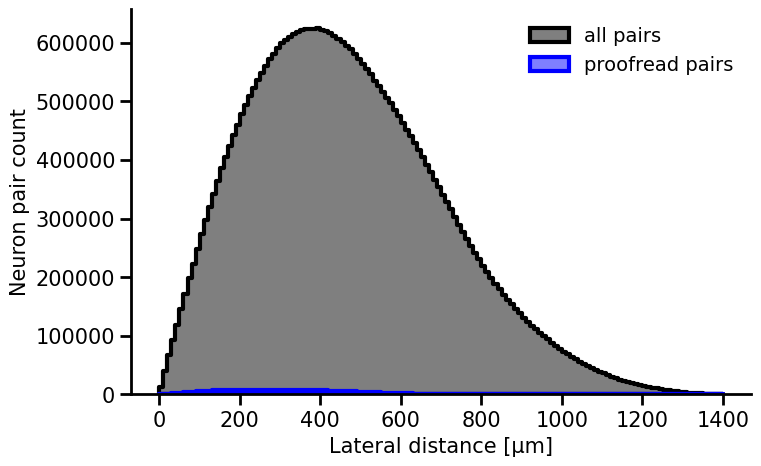

In [14]:
# visualize
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step", label="all pairs")
sns.histplot(lateral_distance_proofread_df, x="distance", fill=True, bins=bins, alpha=.5, color="b", lw=3, element="step", label="proofread pairs")
ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Neuron pair count", fontsize=15)

plt.show()

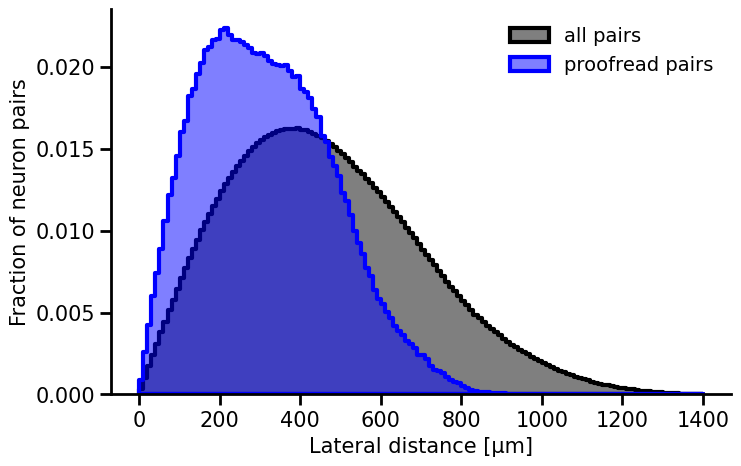

In [15]:
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step", label="all pairs")
sns.histplot(lateral_distance_proofread_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="b", lw=3, element="step", label="proofread pairs")
ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)

plt.show()

In [16]:
#  compare this distribution with the distances between the all connected neuron pairs to see if they differ
analysis_syn_df = filter_synapse_table(syn_df, pre_root_ids, post_root_ids).reset_index(drop=True)

In [17]:
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()
conn_df.head(5)

,pre_pt_root_id,post_pt_root_id,size
0,864691132619294273,864691132579004178,4108
1,864691132619294273,864691132732883676,1704
2,864691132619294273,864691132749759207,1172
3,864691132619294273,864691132780963967,2643
4,864691132619294273,864691132785302924,3398


In [18]:
lateral_distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
0,864691132596373823,864691132654552792,399.650263
1,864691132596373823,864691132956447079,356.686618
2,864691132596373823,864691132726948075,900.180007
3,864691132596373823,864691132717799744,750.574113
4,864691132596373823,864691132656979312,717.464930


In [19]:
# merge conn_df and lateral_distance_df
conn_dist_df = pd.merge(conn_df, lateral_distance_df,on = ["pre_pt_root_id", "post_pt_root_id"])
conn_dist_df.head()

,pre_pt_root_id,post_pt_root_id,size,distance
0,864691132619294273,864691132579004178,4108,217.776330
1,864691132619294273,864691132732883676,1704,261.047167
2,864691132619294273,864691132749759207,1172,278.313859
3,864691132619294273,864691132780963967,2643,200.308328
4,864691132619294273,864691132785302924,3398,246.779306


In [20]:
conn_dist_df.shape, conn_df.shape, lateral_distance_df.shape

((98, 4), (98, 3), (38445884, 3))

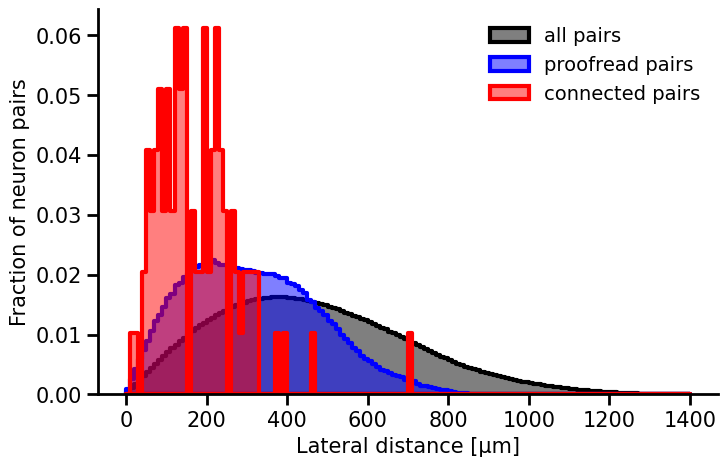

In [21]:
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step", label="all pairs")
sns.histplot(lateral_distance_proofread_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="b", lw=3, element="step", label="proofread pairs")
sns.histplot(conn_dist_df, x="distance", stat="proportion", bins=bins, element="step", lw=3, fill=True, alpha=.5, color="r", label="connected pairs")
ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)

plt.show()

In [22]:
bins = np.linspace(0, 500, 101) # 5µm bins

# Binned counts for proofread and connected pairs
proofread_pair_counts = np.histogram(lateral_distance_proofread_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

# Fraction of counts between connected and proofread pairs
connection_probability = connected_pair_counts / proofread_pair_counts
connection_probability_df = pd.DataFrame({"bin_id": np.arange(len(bins)-1), "probability": connection_probability})

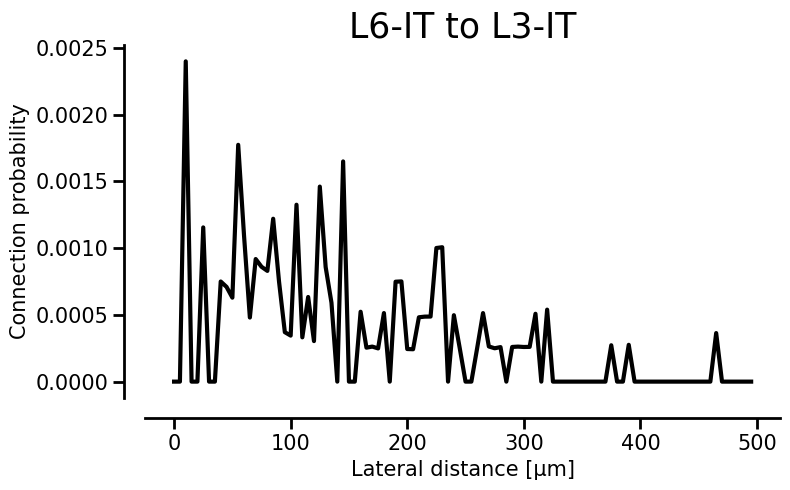

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=bins[:-1], y=connection_probability, lw=3, color="k")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Connection probability", fontsize=15)
ax.set_title("L6-IT to L3-IT", fontsize=25)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.savefig("L6IT.png") 
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Repeat the analysis above for different cell types, e.g., switch from PTC to DTC. How does the plot above change?

</div>